### 0. Notebook setup

In [1]:
COLAB = False # Set this to True if you want to install the libraries and clone the repository in Colab
USE_DOTENV = True # Set this to False if you don't have a .env file for storing environment variables

if COLAB:
    USE_DOTENV = False
    dotenv_path = None
    from google.colab import userdata
    colab_secrets = {'HF_TOKEN': userdata.get('HF_TOKEN'), 'HF_TOKEN_WRITE': userdata.get('HF_TOKEN_WRITE')}
    !pip install datasets
    !git clone https://github.com/reddgr/zero-shot-text-classification
    import os
    os.system("mv zero-shot-text-classification zs_tc")

if USE_DOTENV: 
    COLAB=False
    dotenv_path = "../../../../../apis/.env"
    colab_secrets = None

from transformers import pipeline, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification, AutoTokenizer,  AdamW, Trainer, TrainingArguments
import tensorflow as tf
import random
from datasets import load_dataset, Dataset
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
import sys
import os
import torch
import textwrap
from IPython.display import clear_output
import matplotlib.pyplot as plt

if COLAB:
    import sys
    sys.path.append("./zs_tc/src")
    import env_options, nli_labeling_widget as labeling_widget, text_classification_functions as tcf, lmsys_dataset_handler as lmsys
else:
    import sys
    sys.path.append("./src")
    import text_classification_functions as tcf
    import env_options
    import lmsys_dataset_handler as lmsys
    import nli_finetuning_utils

hf_token, hf_token_write, openai_api_key = env_options.check_env(colab=COLAB, use_dotenv=USE_DOTENV, 
                                                 dotenv_path=dotenv_path, colab_secrets=colab_secrets)


Python version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
PyTorch version: 2.2.2
Transformers version: 4.44.2
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU
CUDA Version: 12.1
FlashAttention available: True
Retrieved token(s) from .env file
Using HuggingFace token: hf_M*****************************IASJ
Using HuggingFace write token: hf_u*****************************Xipx
Using OpenAI token: sk-p************************************************************************************************************************************************************_5sA


In [3]:
### DEBUG ###
import importlib
importlib.reload(nli_finetuning_utils)
importlib.reload(tcf)
### DEBUG ###

<module 'text_classification_functions' from 'c:\\Users\\david\\Documents\\git\\zero-shot-text-classification\\./src\\text_classification_functions.py'>

### Loading the Test split of the dataset

In [23]:
test_dataset_dict = load_dataset("reddgr/nli-chatbot-prompt-categorization")
test_dataset = test_dataset_dict["test"]  # Access the "test" split
test_dataset_df = test_dataset_dict["test"].to_pandas()
print("Labels: ",test_dataset_dict["test"].features["label"]._str2int)
entailments_test_dataset_df = test_dataset_df[test_dataset_df['label'] == 2]
display(entailments_test_dataset_df.head(3))
print(f'... {len(entailments_test_dataset_df)} records ...')
display(entailments_test_dataset_df.tail(3))

Labels:  {'contradiction': 0, 'neutral': 1, 'entailment': 2}


,text,category,label
5,I wanna have a conversation in german to practice,language,2
7,What you think about Belarus?,general knowledge,2
9,Help me rephrase this tagline by giving me a f...,language,2


... 213 records ...


,text,category,label
405,Write some html code that will play a graphics...,coding,2
409,"How do you think, what can be the potential ne...",ai,2
411,When I was 6 my sister was half my age. Now I’...,riddle,2


## Top-12 categories excluding "general knowledge"

Instantiating the zero-shot classifiers:

In [27]:
category_counts = entailments_test_dataset_df['category'].value_counts()
top_n_display = 15
print(f'Top {top_n_display} prompt categories:\n{category_counts.head(top_n_display)}')
category_counts = category_counts[category_counts.index != 'general knowledge']
top_n_categories = 12
top_categories = category_counts.head(top_n_categories).index
test_entailments_df = entailments_test_dataset_df[entailments_test_dataset_df['category'].isin(top_categories)]
print(f'{len(test_entailments_df)} records for testing {top_n_categories} categories')
test_entailments_dataset = Dataset.from_pandas(test_entailments_df)
print(test_entailments_dataset)
print(top_categories.to_list())

Top 15 prompt categories:
category
coding               39
technology           25
language             20
writing              20
science              19
business             18
popular culture      11
role play            10
general knowledge     9
riddle                8
finance               5
ai                    5
philosophy            4
images                3
mathematics           3
Name: count, dtype: int64
184 records for testing 12 categories
Dataset({
    features: ['text', 'category', 'label', '__index_level_0__'],
    num_rows: 184
})
['coding', 'technology', 'language', 'writing', 'science', 'business', 'popular culture', 'role play', 'riddle', 'finance', 'ai', 'philosophy']


In [28]:
nli_model_path = 'reddgr/zero-shot-prompt-classifier-bart-ft'
zs_classifier = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)

base_model_path = 'facebook/bart-large-mnli'
base_classifier = tcf.ZeroShotClassifier(base_model_path, base_model_path, top_categories)

c:\Users\david\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Zero-shot classification examples:

In [29]:
text_sample = test_entailments_df.sample(1).text.values[0]
# text_sample = "I'm twice the age you were when i was your age. How old are we?"
ft_result = zs_classifier.classify_text(text_sample, multi_label=False)
base_result = base_classifier.classify_text(text_sample, multi_label=False)
clear_output(wait=True)
print("Classification with fine-tuned model:")
for key, value in ft_result.items():
    print(f"{key}: {value}")

print("Classification with base model:")
for key, value in base_result.items():
    print(f"{key}: {value}")

Classification with fine-tuned model:
sequence: peripheral neuropathy causes
labels: ['science', 'ai', 'riddle', 'popular culture', 'business', 'role play', 'language', 'writing', 'finance', 'philosophy', 'coding', 'technology']
scores: [0.417, 0.295, 0.051, 0.035, 0.032, 0.03, 0.028, 0.027, 0.025, 0.025, 0.021, 0.015]
Classification with base model:
sequence: peripheral neuropathy causes
labels: ['ai', 'riddle', 'science', 'language', 'popular culture', 'writing', 'role play', 'coding', 'philosophy', 'business', 'technology', 'finance']
scores: [0.45, 0.143, 0.091, 0.065, 0.051, 0.04, 0.038, 0.036, 0.028, 0.023, 0.018, 0.017]


In [ ]:
df_testing = test_entailments_df.sample(10).copy()
df_testing_zs = zs_classifier.classify_dataframe_column(df_testing, target_column = 'text', feature_suffix = 'zs')
# Add a column to indicate if the prediction was correct
df_testing_zs['is_correct'] = (
    df_testing_zs['category'] == df_testing_zs['top_class_zs']
).astype(int)
# Calculate accuracy of the sample:
sample_accuracy = df_testing_zs['is_correct'].mean() * 100
print(f"Sample accuracy: {sample_accuracy:.1f}%")
display(df_testing_zs)

100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

Sample accuracy: 80.0%


,text,category,label,top_class_zs,top_score_zs,full_results_zs,is_correct
136,Which is the maximum fitness for an individual...,coding,2,science,0.420,"[(science, 0.42), (technology, 0.258), (riddle...",0
49,"give me a project idea for python, rabbitmq, m...",coding,2,technology,0.446,"[(technology, 0.446), (coding, 0.409), (ai, 0....",0
132,Make a very annoying email with lots of errors...,role play,2,role play,0.365,"[(role play, 0.365), (language, 0.2), (writing...",1
69,Do you something about the company tractable?,business,2,business,0.585,"[(business, 0.585), (ai, 0.12), (role play, 0....",1
25,You can make it in CSV format,coding,2,coding,0.523,"[(coding, 0.523), (technology, 0.155), (busine...",1
205,Let's talk about macro finance,finance,2,finance,0.663,"[(finance, 0.663), (business, 0.107), (ai, 0.1...",1
334,What is the smallest integer whose square is b...,riddle,2,riddle,0.400,"[(riddle, 0.4), (science, 0.249), (ai, 0.067),...",1
287,is SEO part of the Web Analytics discipline?,technology,2,technology,0.602,"[(technology, 0.602), (ai, 0.1), (riddle, 0.07...",1
352,"how can I translate ""self-deprecating"" to Span...",language,2,language,0.547,"[(language, 0.547), (riddle, 0.105), (ai, 0.08...",1
219,do worms start eating a body from inside,science,2,science,0.486,"[(science, 0.486), (ai, 0.146), (riddle, 0.108...",1


Zero-shot classification with facebook/bart-large-mnli: 100%|██████████| 187/187 [00:40<00:00,  4.61it/s]


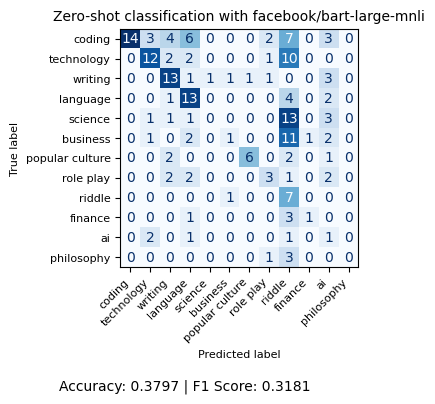

In [ ]:
base_test_metrics = base_classifier.test_zs_predictions(test_entailments_df)

Zero-shot classification with reddgr/zero-shot-prompt-classifier-bart-ft: 100%|██████████| 187/187 [00:40<00:00,  4.58it/s]


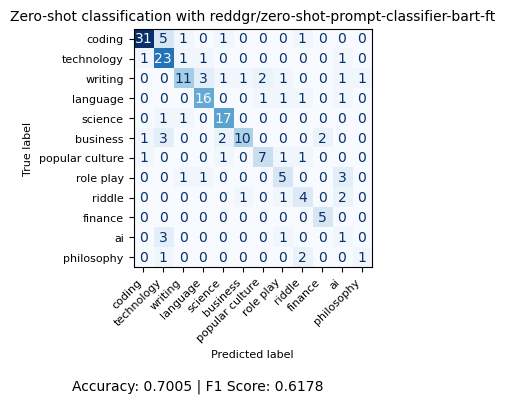

In [ ]:
zs_test_metrics = zs_classifier.test_zs_predictions(test_entailments_df)

Sample results:

In [ ]:
zs_test_metrics.get('detailed_results')
results_df = pd.DataFrame(zs_test_metrics['detailed_results'])
display(results_df.sample(5))
results_df.to_csv('csv/12c-test.csv', index=False)

,text,category,label,predicted_class
55,What's the sum of all integer values from 2 to...,riddle,2,riddle
16,"Good answer 🤣 In two words, is there a movie, ...",popular culture,2,popular culture
191,Code to filter odd numbers in an array. Use c++,coding,2,coding
294,Explain this notes taken in Spanish about the ...,science,2,science
83,That's pretty good - but it is not an Interfac...,coding,2,coding


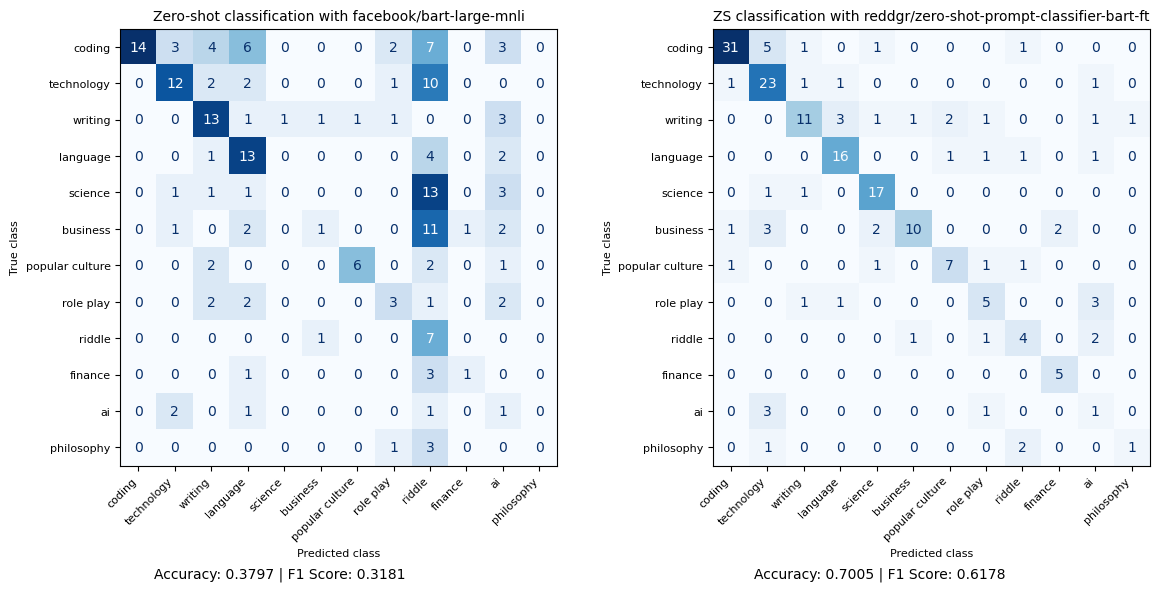

In [ ]:
metrics_comp = tcf.MetricsComparison(base_classifier, zs_classifier, base_test_metrics, zs_test_metrics)
metrics_comp.compare_conf_matrices()

Accuracy by labeled category:

In [ ]:
zs_test_metrics.get('detailed_results')
results_df = pd.DataFrame(zs_test_metrics['detailed_results'])
results_by_category = results_df.groupby(['category', 'predicted_class']).size().unstack(fill_value=0)
accuracy_by_category = results_df.groupby('category').apply(lambda x: (x['category'] == x['predicted_class']).mean())

print("\nAccuracy by category:")
for category in top_categories:
    print(f"{category:20} {accuracy_by_category[category]:.3f}")

print("\nResults sample:")
display(results_df.sample(5))


Accuracy by category:
coding               0.795
technology           0.852
writing              0.524
language             0.800
science              0.895
business             0.556
popular culture      0.636
role play            0.500
riddle               0.500
finance              1.000
ai                   0.200
philosophy           0.250

Results sample:


,text,category,label,predicted_class
205,Let's talk about macro finance,finance,2,finance
365,what is the most efficient Thermoelectric gene...,technology,2,technology
405,"You're my mum NAME_1, 40 years old. From Ports...",role play,2,role play
80,"Can you interact with other systems, apart fro...",technology,2,technology
200,Are you in anyway related to NAME_1 in strange...,popular culture,2,riddle


## Top-10 Categories

In [30]:
category_counts = entailments_test_dataset_df['category'].value_counts()
top_n_display = 12
print(f'Top {top_n_display} prompt categories:\n{category_counts.head(top_n_display)}')
category_counts = category_counts[category_counts.index != 'general knowledge']
top_n_categories = 10
top_categories = category_counts.head(top_n_categories).index
test_entailments_df = entailments_test_dataset_df[entailments_test_dataset_df['category'].isin(top_categories)]
print(f'{len(test_entailments_df)} records for testing {top_n_categories} categories')
print(top_categories.to_list())

nli_model_path = 'reddgr/zero-shot-prompt-classifier-bart-ft'
zs_classifier = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)

base_model_path = 'facebook/bart-large-mnli'
base_classifier = tcf.ZeroShotClassifier(base_model_path, base_model_path, top_categories)

Top 12 prompt categories:
category
coding               39
technology           25
language             20
writing              20
science              19
business             18
popular culture      11
role play            10
general knowledge     9
riddle                8
finance               5
ai                    5
Name: count, dtype: int64
175 records for testing 10 categories
['coding', 'technology', 'language', 'writing', 'science', 'business', 'popular culture', 'role play', 'riddle', 'finance']


c:\Users\david\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [13]:
base_model_path = 'facebook/bart-large-mnli'
base_classifier = tcf.ZeroShotClassifier(base_model_path, base_model_path, top_categories)
nli_model_path = 'reddgr/zero-shot-prompt-classifier-bart-ft'
zs_classifier = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)
base_test_metrics = base_classifier.test_zs_predictions(test_entailments_df, plot_conf_matrix=False)
zs_test_metrics = zs_classifier.test_zs_predictions(test_entailments_df, plot_conf_matrix=False)

Zero-shot classification with facebook/bart-large-mnli: 100%|██████████| 178/178 [08:16<00:00,  2.79s/it]
Zero-shot classification with reddgr/zero-shot-prompt-classifier-bart-ft: 100%|██████████| 178/178 [04:37<00:00,  1.56s/it]


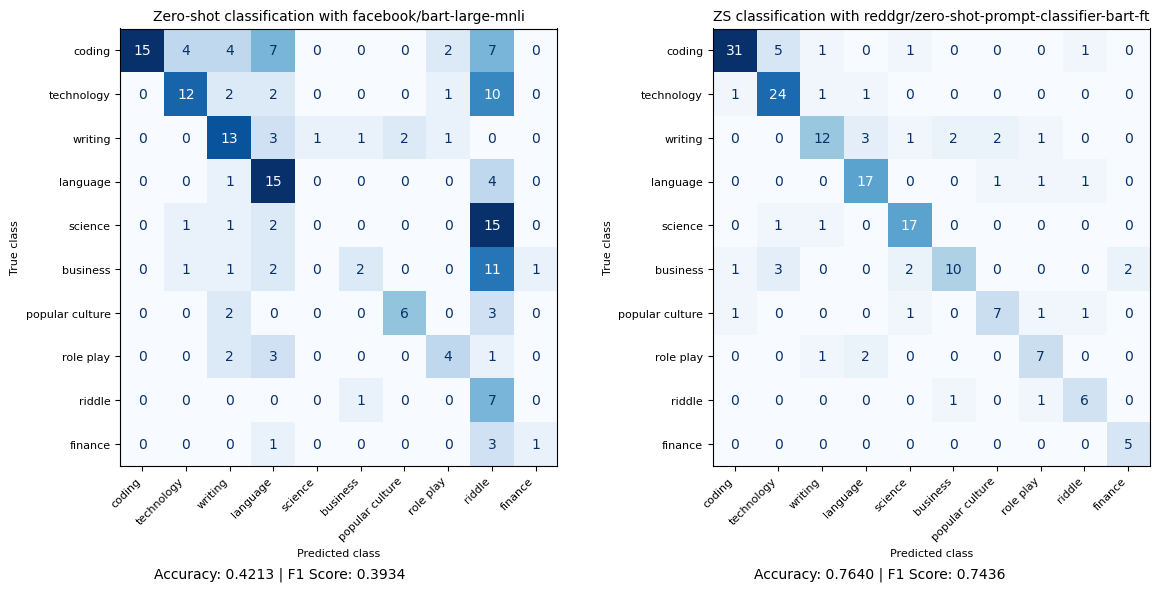

In [14]:
metrics_comp = tcf.MetricsComparison(base_classifier, zs_classifier, base_test_metrics, zs_test_metrics)
metrics_comp.compare_conf_matrices()

In [15]:
zs_test_metrics.get('detailed_results')
results_df = pd.DataFrame(zs_test_metrics['detailed_results'])
results_by_category = results_df.groupby(['category', 'predicted_class']).size().unstack(fill_value=0)
accuracy_by_category = results_df.groupby('category').apply(lambda x: (x['category'] == x['predicted_class']).mean())

print("\nAccuracy by category:")
for category in top_categories:
    print(f"{category:20} {accuracy_by_category[category]:.3f}")

print("\nResults sample:")
display(results_df.sample(5))


Accuracy by category:
coding               0.795
technology           0.889
writing              0.571
language             0.850
science              0.895
business             0.556
popular culture      0.636
role play            0.700
riddle               0.750
finance              1.000

Results sample:


,text,category,label,predicted_class
20,I found some MarketWatch articles by Michael A...,finance,2,finance
343,let's get back to the bash script. What does t...,coding,2,coding
285,“Photorealism in CGI has arguably been achieve...,technology,2,technology
37,"what is an equivalent term for ""day to day con...",language,2,language
40,Find song lyrics which mention something like ...,popular culture,2,popular culture


Riddle example:

In [16]:
# text_sample = test_entailments_df.sample(1).text.values[0]
text_sample = "I'm twice the age you were when i was your age. How old are we?"
ft_result = zs_classifier.classify_text(text_sample, multi_label=False)
base_result = base_classifier.classify_text(text_sample, multi_label=False)
clear_output(wait=True)

print("\nClassification with base model:")
for key, value in base_result.items():
    print(f"{key}: {value}")

print("\nClassification with fine-tuned model:")
for key, value in ft_result.items():
    print(f"{key}: {value}")



Classification with base model:
sequence: I'm twice the age you were when i was your age. How old are we?
labels: ['riddle', 'language', 'role play', 'writing', 'popular culture', 'science', 'business', 'technology', 'finance', 'coding']
scores: [0.515, 0.119, 0.075, 0.073, 0.052, 0.04, 0.039, 0.036, 0.026, 0.026]

Classification with fine-tuned model:
sequence: I'm twice the age you were when i was your age. How old are we?
labels: ['riddle', 'role play', 'science', 'business', 'popular culture', 'writing', 'language', 'finance', 'technology', 'coding']
scores: [0.24, 0.19, 0.101, 0.091, 0.089, 0.067, 0.066, 0.059, 0.055, 0.041]


## 6 TTCB Grouped Categories

In [31]:
test_df_grouped = entailments_test_dataset_df.copy()
# test_df_grouped = test_entailments_df.copy()
test_df_grouped.loc[test_df_grouped['category'] == 'business', 'category'] = 'business and finance'
test_df_grouped.loc[test_df_grouped['category'] == 'finance', 'category'] = 'business and finance'
test_df_grouped.loc[test_df_grouped['category'] == 'language', 'category'] = 'language and writing'
test_df_grouped.loc[test_df_grouped['category'] == 'writing', 'category'] = 'language and writing'
test_df_grouped.loc[test_df_grouped['category'] == 'popular culture', 'category'] = 'culture and entertainment'
test_df_grouped.loc[test_df_grouped['category'] == 'music', 'category'] = 'culture and entertainment'
test_df_grouped.loc[test_df_grouped['category'] == 'entertainment', 'category'] = 'culture and entertainment'
test_df_grouped.loc[test_df_grouped['category'] == 'technology', 'category'] = 'technology and ai'
test_df_grouped.loc[test_df_grouped['category'] == 'ai', 'category'] = 'technology and ai'

In [32]:
category_counts = test_df_grouped['category'].value_counts()
top_n_display = 10
print(f'Top {top_n_display} prompt categories:\n{category_counts.head(top_n_display)}')
category_counts = category_counts[category_counts.index != 'general knowledge']
top_n_categories = 6
top_categories = category_counts.head(top_n_categories).index
test_entailments_grouped = test_df_grouped[test_df_grouped['category'].isin(top_categories)]
print(f'{len(test_entailments_grouped)} records for testing {top_n_categories} category groups')
print(top_categories.to_list())

Top 10 prompt categories:
category
language and writing         40
coding                       39
technology and ai            30
business and finance         23
science                      19
culture and entertainment    15
role play                    10
general knowledge             9
riddle                        8
philosophy                    4
Name: count, dtype: int64
166 records for testing 6 category groups
['language and writing', 'coding', 'technology and ai', 'business and finance', 'science', 'culture and entertainment']


Classifying:

In [33]:
base_classifier = tcf.ZeroShotClassifier('facebook/bart-large-mnli', base_model_path, top_categories)
zs_classifier = tcf.ZeroShotClassifier('reddgr/zero-shot-prompt-classifier-bart-ft', nli_model_path, top_categories)
base_test_metrics = base_classifier.test_zs_predictions(test_entailments_grouped, plot_conf_matrix=False)
zs_test_metrics = zs_classifier.test_zs_predictions(test_entailments_grouped, plot_conf_matrix=False)

c:\Users\david\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Zero-shot classification with facebook/bart-large-mnli:   7%|▋         | 11/166 [00:08<01:56,  1.33it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Zero-shot classification with facebook/bart-large-mnli: 100%|██████████| 166/166 [02:12<00:00,  1.26it/s]
Zero-shot classification with reddgr/zero-shot-prompt-classifier-bart-ft: 100%|██████████| 166/166 [00:49<00:00,  3.37it/s]


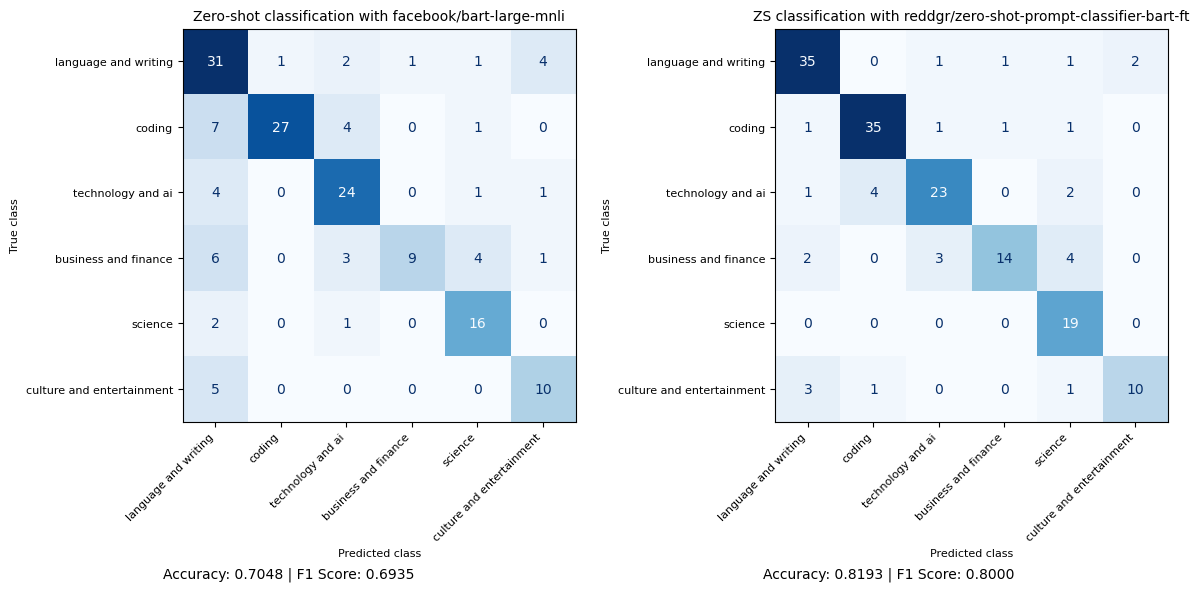

In [34]:
metrics_comp = tcf.MetricsComparison(base_classifier, zs_classifier, base_test_metrics, zs_test_metrics)
metrics_comp.compare_conf_matrices()

______________________________

### Dataset edits

In [11]:
test_dataset_dict = load_dataset("reddgr/nli-chatbot-prompt-categorization")
test_dataset = test_dataset_dict["test"]  # Access the "test" split
test_dataset_df = test_dataset_dict["test"].to_pandas()
print("Labels: ",test_dataset_dict["test"].features["label"]._str2int)
print("Entailments examples:")
display(test_dataset_df[test_dataset_df['label']==2].sample(3))

Labels:  {'contradiction': 0, 'neutral': 1, 'entailment': 2}
Entailments examples:


,text,category,label
319,"Elaborate more, now based on your own research...",technology,2
11,Give me a creative sentence for a closed ended...,language,2
305,Find some rock or pop songs that include the w...,popular culture,2


In [18]:
text = "write 10 alternative sentences to this"
test_dataset_df[test_dataset_df['text'].str.contains(text)]

,text,category,label
282,Now let’s write 10 alternative sentences to th...,writing,2
283,Now let’s write 10 alternative sentences to th...,coding,0


In [19]:
text = "write 10 alternative sentences to this"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

In [4]:
text = "following pieces of context to answer the question at the end"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

test = "because the author also created stories about thinkers from other eras"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

text = "create an Email alert in snowflake when ever"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

text = "assist me in composing system architecture"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

text = "tell a joke about"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

text = "threatening DMCA takedown notice"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

In [6]:
text = "sumarize the the answer in a couple"
test_dataset_df.loc[(test_dataset_df['text'].str.contains(text)) 
                    & (test_dataset_df['label'] == 2), 'category'] = 'writing'

text = "correct the spelling for the following text"
test_dataset_df.loc[(test_dataset_df['text'].str.contains(text)) 
                    & (test_dataset_df['label'] == 2), 'category'] = 'writing'

text = "Write below sentence in an alternative way"
test_dataset_df.loc[(test_dataset_df['text'].str.contains(text)) 
                    & (test_dataset_df['label'] == 2), 'category'] = 'writing'

text = "work is a system of inputs that generates wealth for both the business and"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

text = "but make the responses more succinct and try skipping"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)


text = "discuss your idea to avoid wasting time"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)


text = "This comment was written with ChatGPT assistance"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

In [20]:
from datasets import Dataset, ClassLabel
test_dataset_new = Dataset.from_pandas(test_dataset_df, preserve_index=False)
print(test_dataset_new)

Dataset({
    features: ['text', 'category', 'label'],
    num_rows: 412
})


In [21]:
label_map = {0: "contradiction",1: "neutral",2: "entailment"}
class_label = ClassLabel(names=[label_map[i] for i in sorted(label_map.keys())])
# Map the 'label' feature to the new ClassLabel feature
def map_labels(example):
    example['label'] = class_label.str2int(label_map[example['label']])
    return example
test_dataset_new = test_dataset_new.map(map_labels)
test_dataset_new = test_dataset_new.cast_column("label", class_label)

Map:   0%|          | 0/412 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/412 [00:00<?, ? examples/s]

In [22]:
test_dataset_new.push_to_hub("reddgr/nli-chatbot-prompt-categorization", token=hf_token_write, split='test')

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/reddgr/nli-chatbot-prompt-categorization/commit/7a7630a75a7d64ced05ec469cb7cebbdf0b162ec', commit_message='Upload dataset', commit_description='', oid='7a7630a75a7d64ced05ec469cb7cebbdf0b162ec', pr_url=None, pr_revision=None, pr_num=None)

In [17]:
nli_dataset = load_dataset('reddgr/nli-chatbot-prompt-categorization')
print(f"records in Train split: {len(nli_dataset['train'])}\n...")
display(nli_dataset['train'].to_pandas().tail(3))
print(f"records in Test split: {len(nli_dataset['test'])}\n...")
display(nli_dataset['test'].to_pandas().tail(3))

Generating train split:   0%|          | 0/1854 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/413 [00:00<?, ? examples/s]

records in Train split: 1854
...


,text,category,label
1851,How do you define working capital in the conte...,finance,2
1852,How do you define working capital in the conte...,technology,0
1853,How do you define working capital in the conte...,riddle,0


records in Test split: 413
...


,text,category,label
410,"How do you think, what can be the potential ne...",ai,2
411,When I was 6 my sister was half my age. Now I’...,ai,0
412,When I was 6 my sister was half my age. Now I’...,riddle,2
